<a href="https://colab.research.google.com/github/chabazite/HOML_practice/blob/main/02_housing_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from packaging import version

import sys
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np

import joblib
from scipy import stats
import sklearn
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor,  IsolationForest
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer



In [28]:
assert sys.version_info >= (3,7)

In [29]:


assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [30]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [31]:
def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents = True, exist_ok = True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path='datasets')

  return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [32]:
# look at new data
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## General Descriptive Code for Data

In [33]:
# discription of the fields
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [34]:
# total_bedrooms is missing data, which I will deal with

In [35]:
housing['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [36]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


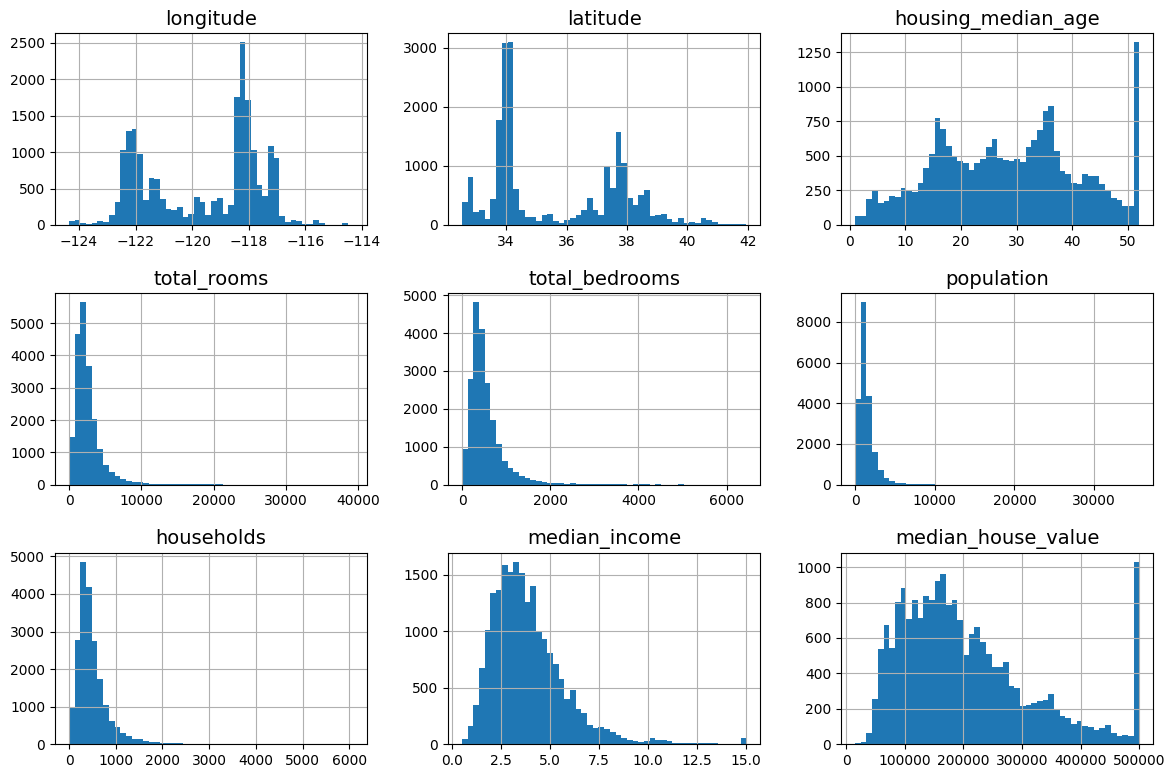

In [37]:

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize = (12,8))
save_fig("attribute_histogram_plots")
plt.show()

1. Median income not expressed in USD: scaled and capped at 15 for higher median incomes and 0.5 for lower meadian incomes. It equates to roughly tens of thousands of dollars (3~30,000)
2. housing median agen and median house value also appear capped: target attributee being capped may be an issue, no prices beyond the limit.
3. Attributes have very different scales.
4. histograms are right-skewed mostly. Making it difficult for some ML to find patterns

## Create a Test Dataset
- Do this prior to looking at the data, you don't want to find an interesting pattern from the test data, that leads you to select a particular model/feature (overfit to the test data).
-- data snooping bias

In [39]:
def shuffle_and_split_data(data, test_ratio):
  np.random.seed(42)
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]

  return data.iloc[train_indices], data.iloc[test_indices]

In [40]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

In [41]:
housing['income_cat'] = pd.cut(housing['median_income'],
                                  bins =[0., 1.5, 3.0, 4.5, 6., np.inf],
                                  labels = [1, 2, 3, 4, 5])

<function matplotlib.pyplot.show(close=None, block=None)>

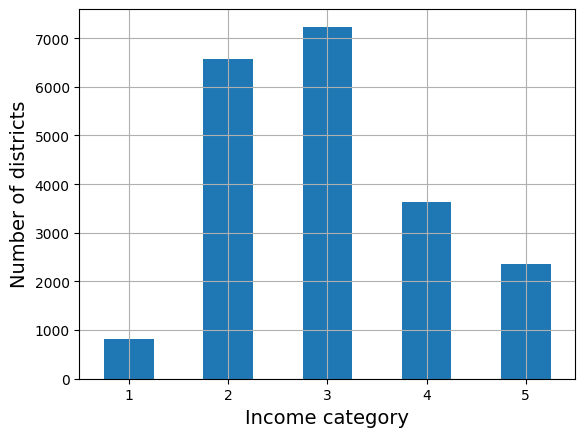

In [42]:
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0,grid=True)

plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show

In [43]:
# Stratified Sampling because Median Income is very important to prediction


splitter= StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing['income_cat']):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])

In [44]:
strat_train_set, strat_test_set = strat_splits[0]

In [45]:
# can also use train_test_split with the stratify option

strat_train_set, strat_test_set = train_test_split(housing, test_size = 0.2, stratify= housing['income_cat'], random_state = 42)

In [46]:
len(strat_train_set), len(strat_test_set)

(16512, 4128)

In [47]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [48]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

,count
income_cat,
3,0.350594
2,0.318859
4,0.176296
5,0.114462
1,0.039789


In [49]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop('income_cat',axis=1, inplace=True)

## EDA Visualize Data

In [50]:
housing = strat_train_set.copy()

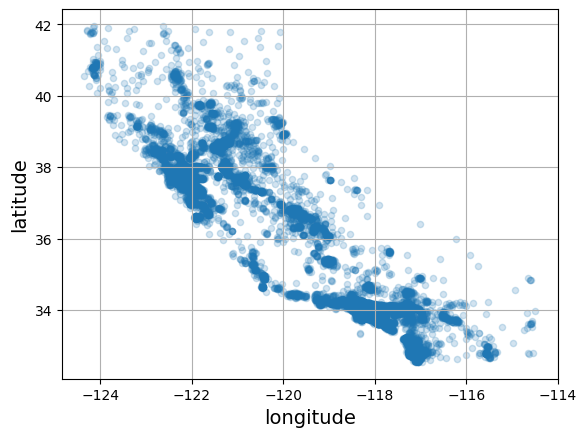

In [51]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.2)
plt.show()

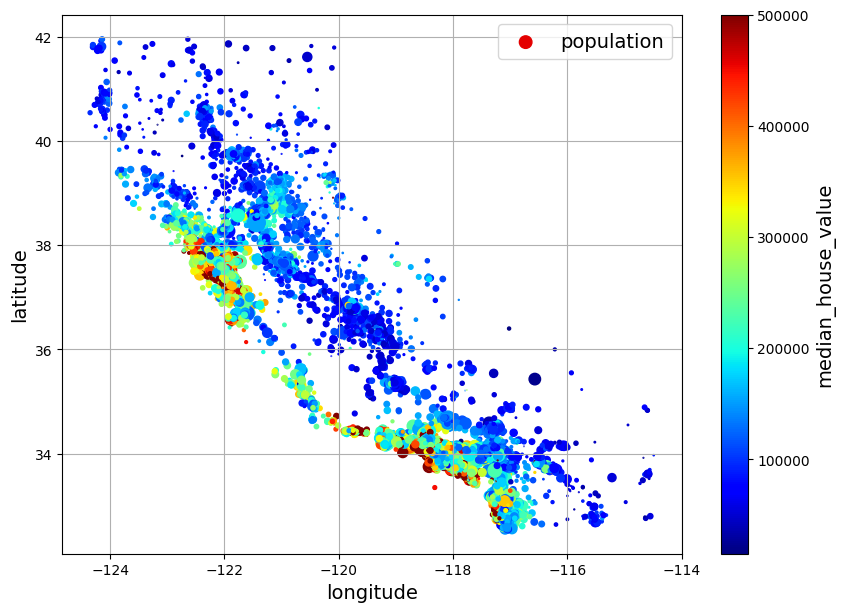

In [52]:
# Housing Prices and Population
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True,
             s=housing['population'] / 100, label='population',
             c='median_house_value', cmap='jet', colorbar=True,
             legend=True, sharex=False, figsize=(10,7))
plt.show()

In [53]:
# Standard Correlation Coeeficient (Pearson's r)
corr_matrix = housing.corr(numeric_only=True)

In [54]:
corr_matrix['median_house_value'].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
longitude,-0.050859
latitude,-0.139584


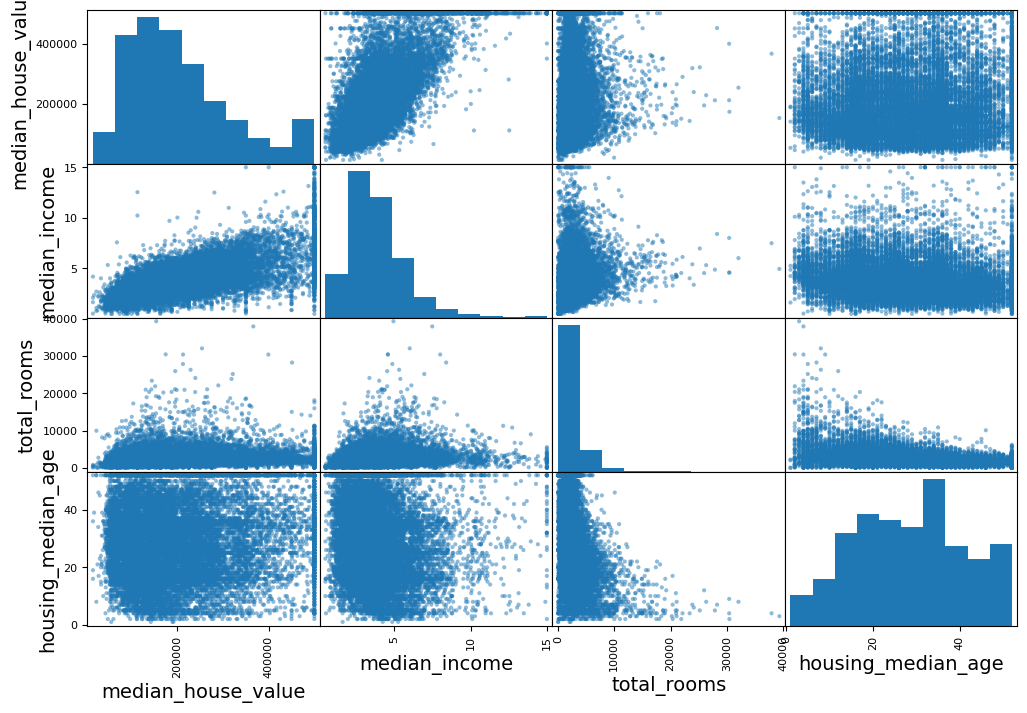

In [55]:

attributes = ['median_house_value','median_income','total_rooms','housing_median_age']

scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

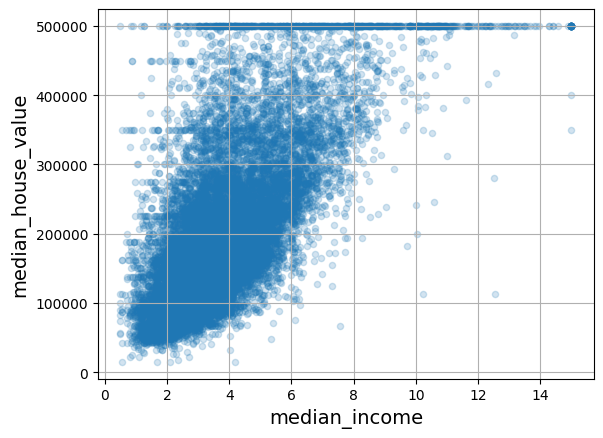

In [56]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', grid=True, alpha=0.2)
plt.show()

## Start Feature Engineering
- rooms_per_house
- bedrooms_ratio
- people_per_house
- transform right skewed data

In [57]:
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']
housing['bedroom_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']

In [58]:
corr_matrix = housing.corr(numeric_only= True)
corr_matrix['median_house_value'].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
rooms_per_house,0.143663
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
people_per_house,-0.038224
longitude,-0.050859


<Axes: >

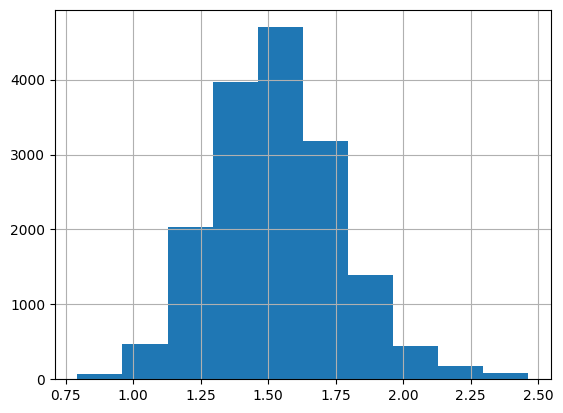

In [59]:
(housing['median_income']**0.333).hist()

In [60]:
housing['total_bedrooms_cube_root']= (housing['total_bedrooms']**(1/3))

<Axes: >

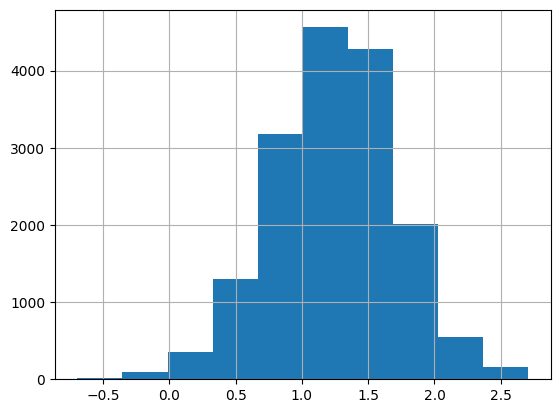

In [61]:
np.log(housing['median_income']).hist()

<Axes: >

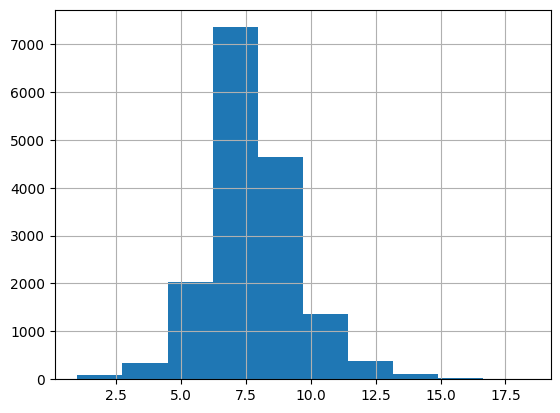

In [62]:
(housing['total_bedrooms']**(1/3)).hist()

<Axes: >

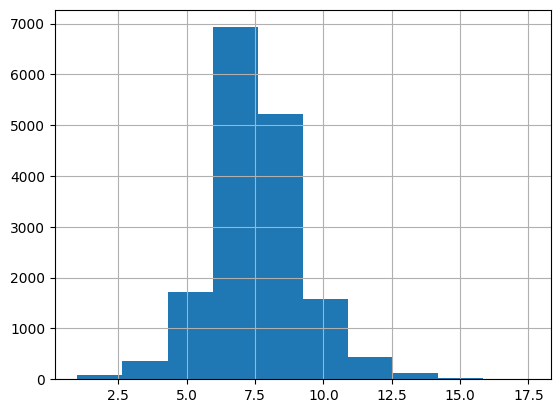

In [63]:
(housing['households']**(1/3)).hist()

In [64]:
housing['rooms_per_house_log'] = np.log(housing['rooms_per_house'])
housing['population_cube_root'] = (housing['population']**(1/3))
housing['households_cobe_root'] = (housing['households']**(1/3))

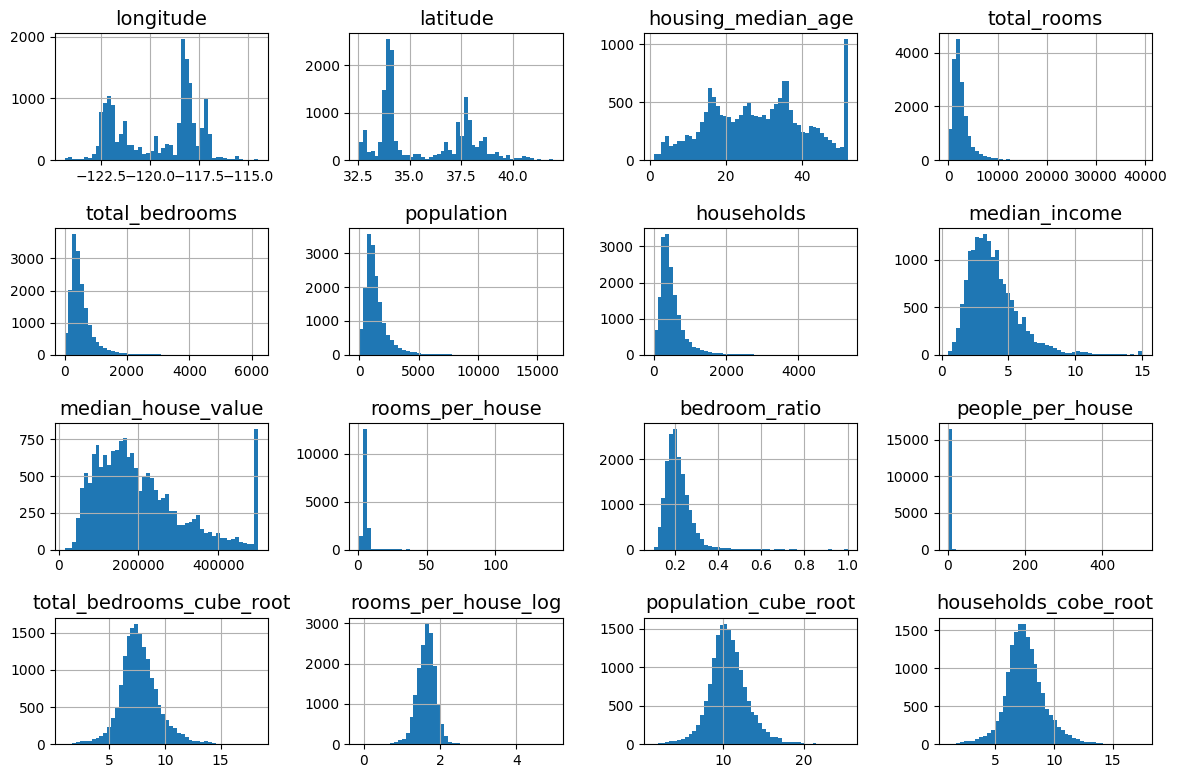

In [65]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize = (12,8))
save_fig("attribute_histogram_plots")
plt.show()

## Prepare the Data for ML

In [66]:
# Clean
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [67]:
# Fill NA
median = housing['total_bedrooms'].median()

housing['total_bedrooms'] = housing['total_bedrooms'].fillna(median)

In [68]:

imputer = SimpleImputer(strategy = 'median')

housing_num = housing.select_dtypes(include = [np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [69]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [70]:
x = imputer.transform(housing_num)

In [71]:
housing_tr = pd.DataFrame(x, columns = housing_num.columns, index=housing_num.index)

In [72]:
# drop outliers

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(x)

In [73]:
housing_labels.count()

16512

In [74]:
housing_o = housing.iloc[outlier_pred == 1]
housing_labels_o = housing_labels.iloc[outlier_pred == 1]

In [75]:
housing_labels_o.count()

14448

In [76]:
# non numerical features
housing_cat = housing[['ocean_proximity']]
housing_cat.head(5)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN


In [77]:

ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [78]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [79]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [80]:
# we shouldn't use ordinal encoding for things that have no given heirachy, the model will say 1, 4 is further apart than 1,2


one_hot_encoder = OneHotEncoder()

housing_cat_1hot = one_hot_encoder.fit_transform(housing_cat)

In [81]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [82]:
housing_cat_1hot.toarray()


array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [83]:
df_test = pd.DataFrame({'ocean_proximity':['INLAND',"NEAR BAY"]})

pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [84]:

min_max_scaler = MinMaxScaler(feature_range = (-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [85]:
#Multi Modal Transformations using RBF

age_simil_35 = rbf_kernel(housing[['housing_median_age']],[[35]],gamma=0.1)

In [86]:

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

In [87]:
model = LinearRegression()

model.fit(housing[['median_income']], scaled_labels)

some_new_data = housing[['median_income']].iloc[:5]

In [88]:
# learn to use inverse_transform
scaled_predictions = model.predict(some_new_data)

predictions = target_scaler.inverse_transform(scaled_predictions)

In [89]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [90]:
# Simpler to use the TransformedTargetRegressor
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer = StandardScaler())
model.fit(housing[['median_income']],housing_labels)
predictions = model.predict(some_new_data)

In [91]:
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

In [139]:
def cube_root(feature):
  return feature**(1/3)

In [166]:
def cubed(feature):
  return feature**(3)

In [167]:
# Custom Transformers

log_transformer = FunctionTransformer(np.log, inverse_func = np.exp)
cube_root_transformer = FunctionTransformer(cube_root, inverse_func = cubed)
log_pop = log_transformer.transform(housing[['population']])

array([[<Axes: title={'center': 'population'}>]], dtype=object)

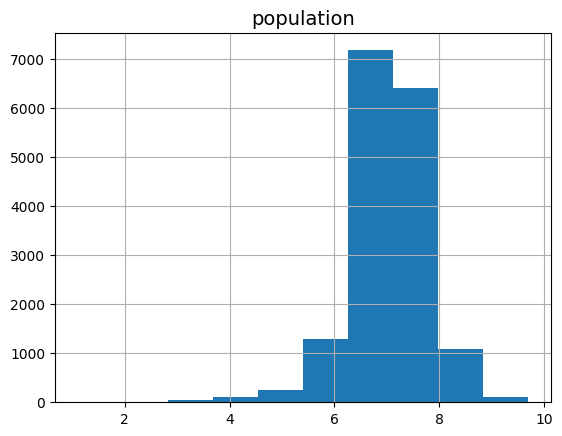

In [168]:
log_pop.hist()

In [169]:
## Create a Custom Scaler Transformer

class StandardScalerClone(BaseEstimator, TransformerMixin):
  def __init__(self, with_mean=True): # no *args or *kwargs!
    self.with_mean = with_mean

  def fit(self, X, y=None): # y is required even though we don't use it
    X = check_array(X) # checks that X is an array with finite float values
    self.mean = X.mean(axis=0)
    self.scale_ = X.std(axis=0)
    self.n_features_in_ = X.shape[1] # every estimator stores this in fit()

    return self # always return self!

  def transform(self, X):
    check_is_fitted(self) # looks for learned attributes (with trailing _)
    X = check_array(X)
    assert self.n_features_in_ == X.shape[1]
    if self.with_mean:
      X = X - self.mean_

    return X / self.scale_

In [170]:
# Cluster similarity transformer


class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state

  def fit(self, X, y=None, sample_weight=None):
    self.kmeans_ = KMeans(self.n_clusters, random_state = self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self

  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

  def get_feature_names_out(self, names=None):
    return [f'Cluster {i} similarity' for i in range(self.n_clusters)]

In [171]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma =1, random_state=42)

similarities = cluster_simil.fit_transform(housing[['latitude','longitude']],
                                           sample_weight=housing_labels)

In [172]:
similarities[:3].round(2)

array([[0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.13, 0.55, 0.  , 0.56],
       [0.64, 0.  , 0.11, 0.04, 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.65, 0.  , 0.  , 0.01, 0.  , 0.49, 0.59, 0.  , 0.28]])

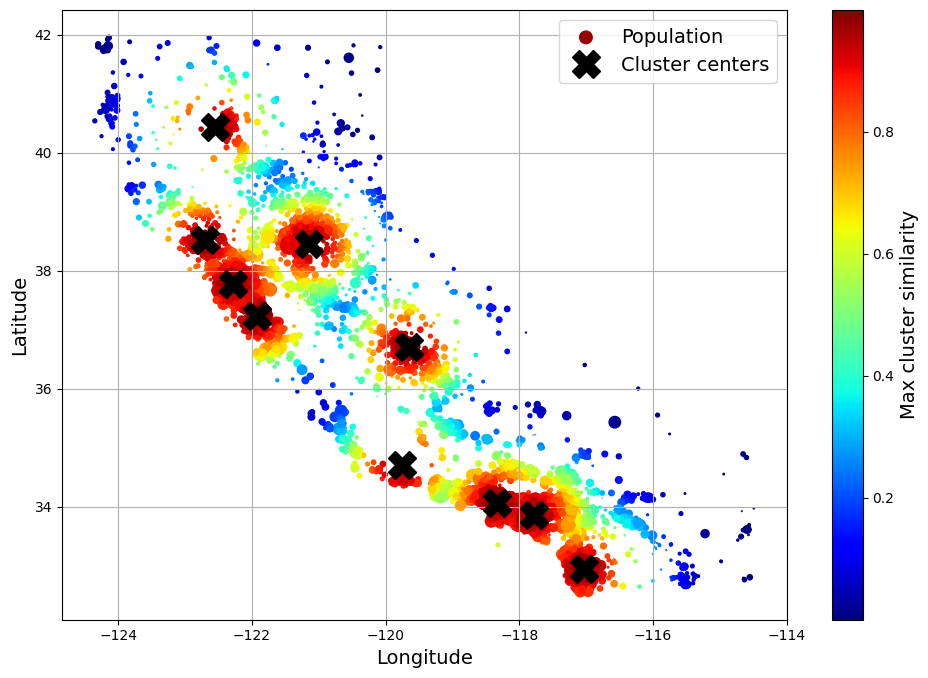

In [173]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

## Create a Pipeline to make the transformations in order

In [174]:

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy='median')),
    ("standardize", StandardScaler())
])

num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

In [175]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [176]:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared,
                                       columns=num_pipeline.get_feature_names_out(),
                                       index=housing_num.index)

In [177]:

num_attribs = ['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income',]
cat_attribs = ['ocean_proximity']

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown = 'ignore')
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [178]:

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
     (cat_pipeline, make_column_selector(dtype_include=object))
)

In [179]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [180]:
housing_prepared = preprocessing.fit_transform(housing)

In [181]:
housing_prepared_df = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out(), index= housing.index)

## Build the full Pipeline

In [182]:
def column_ratio(X):
  return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
  return ['ratio'] #feature names out

def ratio_pipeline():
  return make_pipeline(
      SimpleImputer(strategy='median'),
      FunctionTransformer(column_ratio, feature_names_out=ratio_name),
      StandardScaler()  )

cube_root_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(cube_root, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                    StandardScaler())

preprocessing = ColumnTransformer([
    ('bedrooms', ratio_pipeline(), ['total_bedrooms','total_rooms']),
    ('rooms_per_house', ratio_pipeline(), ['total_rooms','households']),
    ('people_per_house', ratio_pipeline(), ['population','households']),
    ('cube_root', cube_root_pipeline, ['total_bedrooms','total_rooms','population','households','median_income']),
    ('geo', cluster_simil, ['latitude','longitude']),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object))
    ],
                                  remainder=default_num_pipeline)


In [183]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [184]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'cube_root__total_bedrooms',
       'cube_root__total_rooms', 'cube_root__population',
       'cube_root__households', 'cube_root__median_income',
       'geo__Cluster 0 similarity', 'geo__Cluster 1 similarity',
       'geo__Cluster 2 similarity', 'geo__Cluster 3 similarity',
       'geo__Cluster 4 similarity', 'geo__Cluster 5 similarity',
       'geo__Cluster 6 similarity', 'geo__Cluster 7 similarity',
       'geo__Cluster 8 similarity', 'geo__Cluster 9 similarity',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age'],
      dtype=object)

In [185]:

lin_reg = make_pipeline(preprocessing, LinearRegression())

lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x791...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(gamma=1,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x79181ba096f0>)])),
                ('linearregression', LinearRegression())])

In [186]:
housing_predictions = lin_reg.predict(housing)

In [187]:
housing_predictions[:5].round(2)

array([261913.06, 371575.74, 126918.54,  91991.85, 346034.7 ])

In [188]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [189]:

lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)


lin_rmse

66634.60458600057

In [190]:

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x791...
                                                  ClusterSimilarity(gamma=1,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x79181ba096f0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [191]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

### Looks like we have overfit our data!
## Time for Cross Validation

In [192]:

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring = "neg_root_mean_squared_error", cv=10)

In [193]:
pd.Series(tree_rmses).describe()

,0
count,10.000000
mean,67034.167662
std,1472.108176
min,64294.042058
25%,66762.499232
50%,67211.510039
75%,68165.779335
max,68710.413662


In [159]:
# Try RandomForestRegressor since we are clearly overfitting our model

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))

forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring = "neg_root_mean_squared_error", cv=10)

In [160]:
pd.Series(forest_rmses).describe()

,0
count,10.000000
mean,47128.358856
std,1078.659284
min,45298.763890
25%,46730.986070
50%,47163.283772
75%,47577.487166
max,49384.010994


Let's train on the full training with this to see how the overfitting looks

In [161]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = root_mean_squared_error(housing_labels, housing_predictions)
forest_rmse

17520.333533139514

## Here we would look back and see that even RandomForest is overfitting a bit, when we use training data. We can simplify the model, constrain it, or get more data.
- SVM with different kernals or maybe a NN could help us on different categories. We don't want to spend time with HPT since we are shortlisting models. Let's just try a few SVM since NN would be expensive to train and isn't really a simplier model.

In [162]:
## Let's go with this model for now and fine-tune to move through the exercise

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5,8,10],
     'random_forest__max_features': [4,6,8]},
    {'preprocessing__geo__n_clusters':[10,15],
     'random_forest__max_features': [6,8,10]}
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x79181831d420>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [163]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [164]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res = cv_res.sort_values(by='mean_test_score',ascending=False
               )

cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43443,43961,44743,44049
13,15,8,43998,44187,45067,44417
14,15,10,44429,44624,45453,44835
7,10,6,44215,44839,45564,44873
9,10,6,44215,44839,45564,44873


In [165]:
final_model = grid_search.best_estimator_
feature_importances = final_model['random_forest'].feature_importances_
feature_importances.round(2)

array([0.07, 0.05, 0.07, 0.01, 0.01, 0.01, 0.01, 0.26, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.04, 0.01, 0.02, 0.03, 0.02, 0.01, 0.02, 0.02, 0.02,
       0.02, 0.01, 0.1 , 0.  , 0.  , 0.01, 0.02])

In [194]:
sorted(zip(feature_importances, final_model['preprocessing'].get_feature_names_out()), reverse=True)

[(0.26257123249831965, 'cube_root__median_income'),
 (0.1014474513342413, 'cat__ocean_proximity_INLAND'),
 (0.0694903774681289, 'people_per_house__ratio'),
 (0.06593947002665218, 'bedrooms__ratio'),
 (0.05317347430016854, 'rooms_per_house__ratio'),
 (0.04443642799484637, 'geo__Cluster 5 similarity'),
 (0.03331437240982706, 'geo__Cluster 1 similarity'),
 (0.02916084547166939, 'geo__Cluster 0 similarity'),
 (0.02810405116820939, 'geo__Cluster 8 similarity'),
 (0.027581618842439953, 'geo__Cluster 4 similarity'),
 (0.026445595981026186, 'geo__Cluster 2 similarity'),
 (0.025504872663089668, 'geo__Cluster 3 similarity'),
 (0.023179797670386238, 'geo__Cluster 12 similarity'),
 (0.022604403567074396, 'geo__Cluster 7 similarity'),
 (0.0225002773626503, 'geo__Cluster 9 similarity'),
 (0.02212389577112353, 'geo__Cluster 14 similarity'),
 (0.021832768698101534, 'remainder__housing_median_age'),
 (0.02068391444509608, 'geo__Cluster 13 similarity'),
 (0.01694621953297261, 'geo__Cluster 11 similarity

## Evaluated and chose a model, now to test on the best test test

In [195]:
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

In [196]:
final_predictions = final_model.predict(X_test)

In [197]:
final_rmse = root_mean_squared_error(y_test, final_predictions,)
print(final_rmse)

43126.25034506376


In [198]:
# 95% confidence interval for the generalization error if we wanted to compare against another previous version and see if this is actual improvement

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale = stats.sem(squared_errors)))

array([41002.12383665, 45150.55679097])

In [199]:

joblib.dump(final_model, "my_california_housing_model.pkl")

PicklingError: Can't pickle <function column_ratio at 0x791819a4ac20>: it's not the same object as __main__.column_ratio

In [ ]:
import joblib
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor,  IsolationForest
from sklearn.metrics import root_mean_squared_error
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer


def column_ratio(X):
  return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
  return ['ratio'] #feature names out


class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state

  def fit(self, X, y=None, sample_weight=None):
    self.kmeans_ = KMeans(self.n_clusters, random_state = self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self

  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

  def get_feature_names_out(self, names=None):
    return [f'Cluster {i} similarity' for i in range(self.n_clusters)]

  final_model_reloaded = joblib.load('my_california_housin_model.pkl')

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)